# Resampling for regression (resreg) tutorial
## Tutorial 02 - Resampling: techniques for dealing with imbalance in regression problems

In the previous tutorial (01), we saw how to use a relevance function to split target values of a regression problem into a rare domain, which is of greater interest to the user, and a normal domain. Here, using the California housing dataset, we will apply resampling methods to offset the imbalance between the rare and normal domains, in order to improve the predictive performance on high rare values. We will define the rare domain as instances with target values above 3.5.

### Import libaries and dataset

In [15]:
import numpy as np
import itertools
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_california_housing as dataset
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(1, '..')
import resreg

### Retrieve dataset
Since we are interested in decreasing the large error on high values, the rare domain will be formed from only high values (>3.5) by using a right-sided relevance function. 

Text(0, 0.5, 'Relevance')

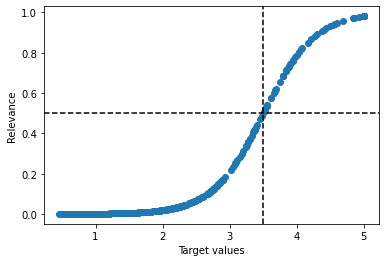

In [16]:
data = dataset()
X = data.data
y = data.target
np.random.seed(seed=0)
sample = np.random.choice(range(len(y)), 500)
X, y = X[sample,:], y[sample]

# Derive relevance values for forming rare and normal domains
# Target values above 3.5 will have relevance values above 0.5,
# all other values will have relevance values below 0.5
relevance = resreg.sigmoid_relevance(y, cl=None, ch=3.5)
plt.scatter(y, relevance)
plt.axhline(0.5, linestyle='--', color='black')
plt.axvline(3.5, linestyle='--', color='black')
plt.xlabel('Target values')
plt.ylabel('Relevance')

### Performance evaluation
A random forest regressor will be fit to the resampled training data. Overall performance will be assessed using the coefficient of determination (r$^2$). But to assess performance on rare high values (>3.5), the F1 score and MSE over bins will be evaluated. Performance will be calculated as an average over 5-fold cross validation results. We will use the F1 score as the primary metric for selecting the best resampling strategies.



In [17]:
# Target values will be split into two bins
# The rare domain (>3.5) and the normal domain (<3.5)
bins = [3.5] 

# Function to fit regressor and evaluate performance
def implementML(X_train, y_train, X_test, y_test, reg):
    reg.fit(X_train, y_train) # fit regressor
    y_pred = reg.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rel_test = resreg.sigmoid_relevance(y_test, cl=None, ch=bins[0]) # relevance values of y_test
    rel_pred = resreg.sigmoid_relevance(y_pred, cl=None, ch=bins[0]) # relevance values of y_pred
    f1 = resreg.f1_score(y_test, y_pred, error_threshold=0.5, relevance_true=rel_test,
                        relevance_pred=rel_pred, relevance_threshold=0.5)
    msebin = resreg.bin_performance(y_test, y_pred, bins=bins, metric='mse')
    return (r2, f1, msebin)


# Function to plot performance results
ticks_font = {'size':'12'}
label_font = {'size':'14'}
title_font = {'size':'16'}

def plotPerformance(msebin, msebinerr, f1, r2, title):
    plt.bar(range(2), msebin, yerr=msebinerr, width=0.4, capsize=3, color='royalblue',
           linewidth=1, edgecolor='black')
    plt.xlim(-0.5, len(bins)+0.5)
    plt.xticks(range(2), ['< {0}'.format(bins[0]), '≥ {0}'.format(bins[0])], **ticks_font)
    plt.yticks(**ticks_font)
    plt.ylabel('Mean Squared Error (MSE)', **label_font)
    plt.xlabel('Target value range', **label_font)
    title = title + '\nf1={0}, r2={1}'.format(round(f1,3), round(r2,3))
    plt.title(title, **title_font)
    plt.show()
    plt.close()

### Without resampling (NONE)
Let us evaluate the performance without applying any resampling techniques.

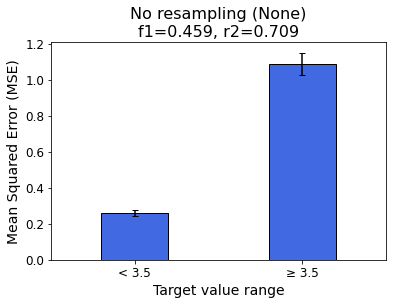

In [18]:
# Empty list for storing results
r2s, f1s, msebins = [], [], []  

# Fivefold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

for train_index, test_index in kfold.split(X):
    X_train, y_train = X[train_index,:], y[train_index]
    X_test, y_test = X[test_index,:], y[test_index]
    reg = RandomForestRegressor(n_estimators=50, max_features=0.5, n_jobs=-1, random_state=0)
    r2, f1, msebin = implementML(X_train, y_train, X_test, y_test, reg) #Fit regressor and evaluate performance
    r2s.append(r2); f1s.append(f1); msebins.append(msebin)

# Average performance
r2, f1, msebin = np.mean(r2s), np.mean(f1s), np.mean(msebins, axis=0)
# Standard error of the mean
r2err, f1err, msebinerr = np.std(r2s)/np.sqrt(5), np.std(f1s)/np.sqrt(5), \
                            np.std(msebins, axis=0)/np.sqrt(5)
# View performance
plotPerformance(msebin, msebinerr, f1, r2, title='No resampling (None)')

# Save performance results
CACHE = {}
CACHE['None'] = [r2, f1, msebin, r2err, f1err, msebinerr]

The error (MSE) on high values (>3.5) is more than four times the error on low values (<3.5). If predicting high values is more important to the user, it is important to improve the performance on high values.

### Random undersampling (RU)
With this strategy, the normal domain is undersampled, while the rare domain is left untouched. The degree of undersampling can be specified as a percentage (float), or three automatic options may be used:
1. *balance*: samples are removed from the normal domain so that it is equal in size to the rare domain
2. *extreme*: samples are removed from the normal domain so that the ratio of sizes is reversed. If the normal domain was five times larger than the rare domain, samples are removed from the normal domain so that the rare domain is five times larger.
3. *average*: intermediate between balance and extreme.

We will determine the optimal degree of undersampling using a grid search. The best undersampling degree will be the one that yields the highest F1 score.

Best parameters:
    under=average


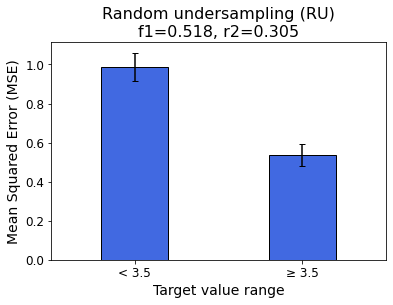

In [9]:
# Degree of undersampling
unders = ['balance', 'average', 'extreme']

# Empty lists for storing results
r2store, f1store, msebinstore = [], [], []
r2errstore, f1errstore, msebinerrstore = [], [], []

# Grid search
for under in unders:
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    r2s, f1s, msebins = [], [], [] 
    # Fivefold cross validation
    for train_index, test_index in kfold.split(X):
        X_train, y_train = X[train_index,:], y[train_index]
        X_test, y_test = X[test_index,:], y[test_index]
        # Resample training data (Random Undersampling)
        relevance = resreg.sigmoid_relevance(y_train, cl=None, ch=bins[0])
        X_train, y_train = resreg.random_undersample(X_train ,y_train, relevance, 
                                    relevance_threshold=0.5, under=under, random_state=0)
        # Fit regressor and evaluate performance
        reg = RandomForestRegressor(n_estimators=50, max_features=0.5, n_jobs=-1, 
                                    random_state=0)
        r2, f1, msebin = implementML(X_train, y_train, X_test, y_test, reg)
        r2s.append(r2)
        f1s.append(f1)
        msebins.append(msebin)
    r2, f1, msebin = np.mean(r2s), np.mean(f1), np.mean(msebins, axis=0)
    r2err, f1err, msebinerr = np.std(r2s)/np.sqrt(5), np.std(f1s)/np.sqrt(5), \
                                np.std(msebins, axis=0)/np.sqrt(5)
    r2store.append(r2); f1store.append(f1); msebinstore.append(msebin)
    r2errstore.append(r2err); f1errstore.append(f1err); msebinerrstore.append(msebinerr)


# Determine the best undersampling degree
best = np.argsort(f1store)[-1] # Which is the best
print('''Best parameters:
    under={0}'''.format(unders[best]))
f1, r2, msebin = f1store[best], r2store[best], msebinstore[best]
f1err, rerr, msebinerr = f1errstore[best], r2errstore[best], msebinerrstore[best]

# Save results
CACHE['RU'] = [r2, f1, msebin, r2err, f1err, msebinerr]                      

# Plot results
plotPerformance(msebin, msebinerr, f1, r2, title='Random undersampling (RU)')


The random undersampling strategy improves the F1 score by 21% and decreases the MSE on high values (>3.5) by 51%. However, the MSE on lower values (>3.5) was increased by 280%. Since the r${^2}$ is biased towards abundant values (<3.5), random undersampling led to a 57% decrease in r${^2}$. A considerable decrease in MSE on high values and a minor increase in MSE on low values, however, is desirable.

### Random oversampling (RO)
With this strategy, the normal domain is left untouched, while the rare domain is oversampled by duplication. The degree of oversampling can be specified as a percentage (float), or as *balance*, *extreme*, or *average*. We will determine the optimal oversampling degree using a grid search.

Best parameters:
    over=extreme


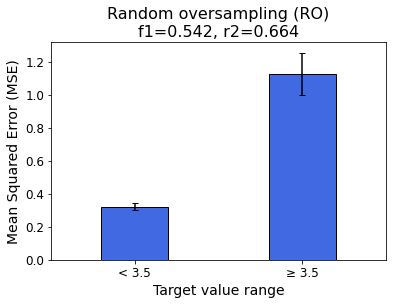

In [10]:
# Degree of oversampling
overs = ['balance', 'average', 'extreme']

# Empty lists for storing results
r2store, f1store, msebinstore = [], [], []
r2errstore, f1errstore, msebinerrstore = [], [], []

# Grid search
for over in overs:
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    r2s, f1s, msebins = [], [], [] 
    # Fivefold cross validation
    for train_index, test_index in kfold.split(X):
        X_train, y_train = X[train_index,:], y[train_index]
        X_test, y_test = X[test_index,:], y[test_index]
        
        # Resample training data (Random Oversampling)
        relevance = resreg.sigmoid_relevance(y_train, cl=None, ch=bins[0])
        X_train, y_train = resreg.random_oversample(X_train ,y_train, relevance, 
                                    relevance_threshold=0.5, over=over, random_state=0)
        
        # Fit regressor and evaluate performance
        reg = RandomForestRegressor(n_estimators=50, max_features=0.5, n_jobs=-1, 
                                    random_state=0)
        r2, f1, msebin = implementML(X_train, y_train, X_test, y_test, reg)
        r2s.append(r2)
        f1s.append(f1)
        msebins.append(msebin)
    r2, f1, msebin = np.mean(r2s), np.mean(f1), np.mean(msebins, axis=0)
    r2err, f1err, msebinerr = np.std(r2s)/np.sqrt(5), np.std(f1s)/np.sqrt(5), \
                                np.std(msebins, axis=0)/np.sqrt(5)
    
    # Store grid search results
    r2store.append(r2); f1store.append(f1); msebinstore.append(msebin)
    r2errstore.append(r2err); f1errstore.append(f1err); msebinerrstore.append(msebinerr)


# Determine the best oversampling degree
best = np.argsort(f1store)[-1] # Which is the best
print('''Best parameters:
    over={0}'''.format(unders[best]))
f1, r2, msebin = f1store[best], r2store[best], msebinstore[best]
f1err, rerr, msebinerr = f1errstore[best], r2errstore[best], msebinerrstore[best]

# Save results
CACHE['RO'] = [r2, f1, msebin, r2err, f1err, msebinerr]                 

# Plot results
plotPerformance(msebin, msebinerr, f1, r2, title='Random oversampling (RO)')


Random oversampling increases the F1 score by 37%, performing better than random undersampling. 

### Synthetic minority oversampling technique for regression (SMOTER)
With SMOTER, the normal domain is undersampled, and the rare domain is oversampled. Oversampling is achieved via generating synthetic cases through interpolation rare values and a random selection of k-nearest neighbors. The user specifies the degree of oversampling and the number of nearest neighbors to select a candidate for interpolation.

Best parameters:
    over=balance; k=5


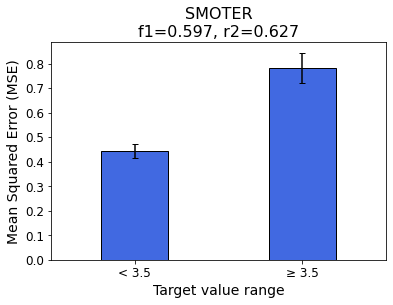

In [11]:
# Parameters
overs = ['balance', 'average', 'extreme']
ks = [5, 10, 15] # nearest neighbors
params = list(itertools.product(overs, ks))

# Empty lists for storing results
r2store, f1store, msebinstore = [], [], []
r2errstore, f1errstore, msebinerrstore = [], [], []

# Grid search
for over, k in params:
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    r2s, f1s, msebins = [], [], [] 
    
    # Fivefold cross validation
    for train_index, test_index in kfold.split(X):
        X_train, y_train = X[train_index,:], y[train_index]
        X_test, y_test = X[test_index,:], y[test_index]
        
        # Resample training data (SMOTER)
        relevance = resreg.sigmoid_relevance(y_train, cl=None, ch=bins[0])
        X_train, y_train = resreg.smoter(X_train, y_train, relevance, 
                                relevance_threshold=0.5, k=k, over=over, random_state=0)
        
        # Fit regressor and evaluate performance
        reg = RandomForestRegressor(n_estimators=50, max_features=0.5, n_jobs=-1, 
                                    random_state=0)
        r2, f1, msebin = implementML(X_train, y_train, X_test, y_test, reg)
        r2s.append(r2)
        f1s.append(f1)
        msebins.append(msebin)
    r2, f1, msebin = np.mean(r2s), np.mean(f1), np.mean(msebins, axis=0)
    r2err, f1err, msebinerr = np.std(r2s)/np.sqrt(5), np.std(f1s)/np.sqrt(5), \
                                np.std(msebins, axis=0)/np.sqrt(5)
    
    # Store grid search results
    r2store.append(r2); f1store.append(f1); msebinstore.append(msebin)
    r2errstore.append(r2err); f1errstore.append(f1err); msebinerrstore.append(msebinerr)


# Determine the best parameters
best = np.argsort(f1store)[-1] # Which is the best
print('''Best parameters:
    over={0}; k={1}'''.format(params[best][0], params[best][1]))
f1, r2, msebin = f1store[best], r2store[best], msebinstore[best]
f1err, rerr, msebinerr = f1errstore[best], r2errstore[best], msebinerrstore[best]

# Save results
CACHE['SMOTER'] = [r2, f1, msebin, r2err, f1err, msebinerr] 

# Plot results
plotPerformance(msebin, msebinerr, f1, r2, title='SMOTER')

The SMOTER strategy improves F1 by 42%, performing better than random undersampling and oversampling.

### Introduction of Gaussian noise (GN)
With this strategy, the normal domain is undersampled and the rare domain is oversampled by generating synthetic cases. Synthetic cases are generated by adding Gaussian noise to the features (X) and to the target values (y) of rare domain instances. The user specifies the degree of oversampling and the amount of noise (*delta*) to be added.

Best parameters:
    over=balance; delta=0.01


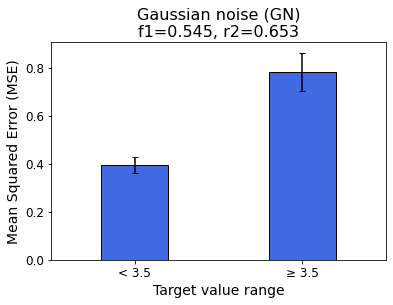

In [12]:
# Parameters
overs = ['balance', 'average', 'extreme']
deltas = [0.01, 0.1, 0.5] # amount of Gaussian noise
params = list(itertools.product(overs, deltas))

# Empty lists for storing results
r2store, f1store, msebinstore = [], [], []
r2errstore, f1errstore, msebinerrstore = [], [], []

# Grid search
for over, delta in params:
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    r2s, f1s, msebins = [], [], [] 
    
    # Fivefold cross validation
    for train_index, test_index in kfold.split(X):
        X_train, y_train = X[train_index,:], y[train_index]
        X_test, y_test = X[test_index,:], y[test_index]
        
        # Resample training data (Gaussian Noise)
        relevance = resreg.sigmoid_relevance(y_train, cl=None, ch=bins[0])
        X_train, y_train = resreg.gaussian_noise(X_train, y_train, relevance, 
                                relevance_threshold=0.5, delta=delta, over=over, 
                                random_state=0)
        
        # Fit regressor and evaluate performance
        reg = RandomForestRegressor(n_estimators=50, max_features=0.5, n_jobs=-1, 
                                    random_state=0)
        r2, f1, msebin = implementML(X_train, y_train, X_test, y_test, reg)
        r2s.append(r2)
        f1s.append(f1)
        msebins.append(msebin)
    r2, f1, msebin = np.mean(r2s), np.mean(f1), np.mean(msebins, axis=0)
    r2err, f1err, msebinerr = np.std(r2s)/np.sqrt(5), np.std(f1s)/np.sqrt(5), \
                                np.std(msebins, axis=0)/np.sqrt(5)
    
    # Store grid search results
    r2store.append(r2); f1store.append(f1); msebinstore.append(msebin)
    r2errstore.append(r2err); f1errstore.append(f1err); msebinerrstore.append(msebinerr)


# Determine the best parameters
best = np.argsort(f1store)[-1] # Which is the best
print('''Best parameters:
    over={0}; delta={1}'''.format(params[best][0], params[best][1]))
f1, r2, msebin = f1store[best], r2store[best], msebinstore[best]
f1err, rerr, msebinerr = f1errstore[best], r2errstore[best], msebinerrstore[best]

# Save results
CACHE['GN'] = [r2, f1, msebin, r2err, f1err, msebinerr] 

# Plot results
plotPerformance(msebin, msebinerr, f1, r2, title='Gaussian noise (GN)')

Introduction of Gaussian noise improves F1 by 23% which outperforms random undersampling, but underperforms random oversampling and SMOTER.

### Weighted relevance-based combination strategy (WERCS)
With this strategy, target values are not split into rare and normal domains. Rather, relevance values are used as weights (probabilities) to select samples for undersampling and oversampling. Instances with high relevance values have higher probabilties of being selected for oversampling and lower probabilities of being selected for undersampling. The user specifies the percentage of oversampling and undersampling (float). Rather than duplicating samples in the oversampling step, Gaussian noise can be added to the samples by specifying *noise*=True as well as the amount of noise (*delta*).

Best parameters:
    over=1.0; under=0.75; noise=True; delta=0.5


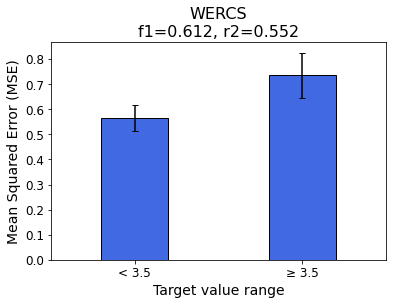

In [21]:
# Parameters
overs = [0.5, 0.75, 1.0] # percent of samples added
unders = [0.5, 0.75] # percent of samples removed
noises = [True, False] # Whether to add Gaussian noise to oversampled data
deltas = [0.01, 0.1, 0.5] # amount of Gaussian noise
params = list(itertools.product(overs, unders, [noises[1]])) + \
            list(itertools.product(overs, unders, [noises[0]], deltas))

# Empty lists for storing results
r2store, f1store, msebinstore = [], [], []
r2errstore, f1errstore, msebinerrstore = [], [], []

# Grid search
for param in params:
    if len(param)==4:
        over, under, noise, delta = param
    else:
        over, under, noise = param
        delta = None
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    r2s, f1s, msebins = [], [], [] 
    
    # Fivefold cross validation
    for train_index, test_index in kfold.split(X):
        X_train, y_train = X[train_index,:], y[train_index]
        X_test, y_test = X[test_index,:], y[test_index]
        
        # Resample training data (WERCS)
        relevance = resreg.sigmoid_relevance(y_train, cl=None, ch=bins[0])
        X_train, y_train = resreg.wercs(X_train, y_train, relevance, over=over,
                              under=under, noise=noise, delta=delta, random_state=0)
        
        # Fit regressor and evaluate performance
        reg = RandomForestRegressor(n_estimators=50, max_features=0.5, n_jobs=-1, 
                                    random_state=0)
        r2, f1, msebin = implementML(X_train, y_train, X_test, y_test, reg)
        r2s.append(r2)
        f1s.append(f1)
        msebins.append(msebin)
    r2, f1, msebin = np.mean(r2s), np.mean(f1), np.mean(msebins, axis=0)
    r2err, f1err, msebinerr = np.std(r2s)/np.sqrt(5), np.std(f1s)/np.sqrt(5), \
                                np.std(msebins, axis=0)/np.sqrt(5)
    
    # Store grid search results
    r2store.append(r2); f1store.append(f1); msebinstore.append(msebin)
    r2errstore.append(r2err); f1errstore.append(f1err); msebinerrstore.append(msebinerr)


# Determine the best parameters
best = np.argsort(f1store)[-1] # Which is the best
bestparam = params[best]
if len(param)==4:
    over, under, noise, delta= param
else:
    over, under, noise = param
    delta = None
print(f'''Best parameters:
    over={over}; under={under}; noise={noise}; delta={delta}''')
f1, r2, msebin = f1store[best], r2store[best], msebinstore[best]
f1err, rerr, msebinerr = f1errstore[best], r2errstore[best], msebinerrstore[best]

# Save results
CACHE['WERCS'] = [r2, f1, msebin, r2err, f1err, msebinerr] 

# Plot results
plotPerformance(msebin, msebinerr, f1, r2, title='WERCS')

The WERCS strategy improves F1 score by 55%, outperforming all other strategies. The downside to the WERCS strategy is that there are more hyperparameters to optimize.

### Plot performance of all resampling methods

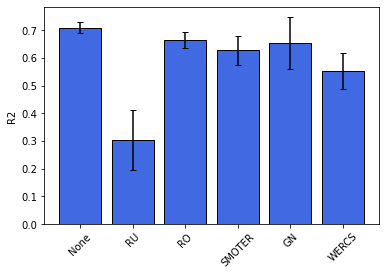

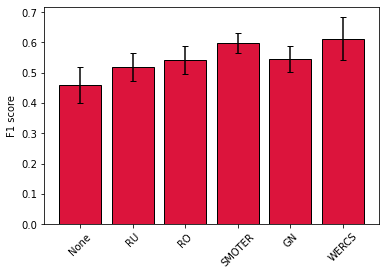

<function matplotlib.pyplot.show(*args, **kw)>

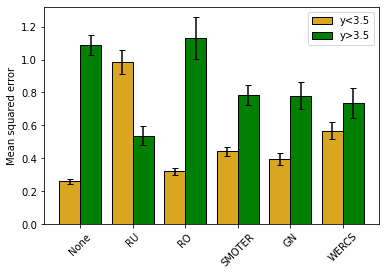

In [14]:
# Data from CACHE
r2s = [val[0] for val in CACHE.values()]
r2errs = [val[3] for val in CACHE.values()]
f1s = [val[1] for val in CACHE.values()]
f1errs = [val[4] for val in CACHE.values()]
msebins = np.asarray([val[2] for val in CACHE.values()])
msebinerrs = np.asarray([val[5] for val in CACHE.values()])
keys = CACHE.keys()

# Plot r2
plt.bar(range(len(keys)), r2s, yerr=r2errs, capsize=3, color='royalblue',
       linewidth=1, edgecolor='black')
_ = plt.xticks(range(len(keys)), keys, rotation=45)
plt.ylabel('R2')
plt.show()

# Plot F1
plt.bar(range(len(keys)), f1s, yerr=f1errs, capsize=3, color='crimson',
       linewidth=1, edgecolor='black')
_ = plt.xticks(range(len(keys)), keys, rotation=45)
plt.ylabel('F1 score')
plt.show()

# Plot MSE over bins
plt.bar(np.arange(len(keys))-0.2, msebins[:,0], width=0.4, yerr=msebinerrs[:,0],
       capsize=3, color='goldenrod', linewidth=1, edgecolor='black', label='y<3.5')
plt.bar(np.arange(len(keys))+0.2, msebins[:,1], width=0.4, yerr=msebinerrs[:,1],
       capsize=3, color='green', linewidth=1, edgecolor='black', label='y>3.5')
_ = plt.xticks(range(len(keys)), keys, rotation=45)
plt.ylabel('Mean squared error')
plt.legend()
plt.show
#print(msebins)

From the plots, you can see that the WERCS resampling strategy achieves a similar MSEs for the rare and normal domain, as well as the highest F1 score.

### Save results

In [11]:
joblib.dump(CACHE, 'cache.pkl')

['cache.pkl']